# 변동성 목표 전략 + 모멘텀 전략

- 주식투자비중 = 변동성 목표 투자 비중x상대 모멘텀 비중 스코어

- 현금비중 = 1-주식투자 비중


In [ ]:
# - 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
# - 구해진 수익률의 표준편차 계산
# - 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
# - 나머지 투자 비중 = 현금 보유

# XXX 필요하면 weights를 구해서 WeighTarget Algo로 해도 된다.
class WeighTargetVol(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
    """
    def __init__(self, targetvol=0.01, months=6, lag=pd.DateOffset(days=0), cash='현금'):
        super(WeighTargetVol, self).__init__()
        self.targetvol = targetvol
        self.lookback = months
        self.lag = lag
        self.cash = cash

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        
        t0 = target.now - self.lag
        selected.remove(self.cash)

        start = t0 - pd.DateOffset(months=self.lookback)
        prc = target.universe.loc[start:t0, selected]

        # 월별 수익률의 변동성
        mret = prc.resample('M').last().pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률
        if std.values[0] > self.targetvol:
            weights = pd.Series(self.targetvol/std, index=selected)
        else:
            print("@@@ 몰빵!!!")
            weights = pd.Series(1.0, index=selected)
        weights[self.cash] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [1]:
from settings import * 

In [2]:
data_daily = get_data()[['kodex200', 'kbond3y']]
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5433 entries, 2000-01-04 to 2021-12-30
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5433 non-null   float64
 1   kbond3y   5433 non-null   float64
dtypes: float64(2)
memory usage: 127.3 KB


In [3]:
s = '2001-1-30'
e = '2021-12-30'
# e = '2022-02-23'
start = '2002-2-1'

In [4]:
data_daily = data_daily[s:e]

In [5]:
data_daily

,kodex200,kbond3y
Date,,
2001-01-30,5154.203,54262.366
2001-01-31,5399.557,54297.828
2001-02-01,5350.652,54333.248
2001-02-02,5311.437,54420.825
2001-02-05,5046.944,54492.264
...,...,...
2021-12-24,40115.000,111870.000
2021-12-27,39880.000,111935.000
2021-12-28,40205.000,111865.000


## 변동성 목표 전략 + 모멘텀 전략

%%
- 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
- 구해진 수익률의 표준편차 계산
- 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
- 나머지 투자 비중 = 현금 보유

In [15]:

class WeighTargetVol(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
    """
    def __init__(self, targetvol=0.01, months=6, cash='현금'):
        super(WeighTargetVol, self).__init__()
        self.targetvol = targetvol
        self.lookback = months
        self.cash = cash

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash)
        
        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False          

        # 월별 수익률의 변동성
        mret = prc.pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률
        if std.values[0] > self.targetvol:
            weights = pd.Series(self.targetvol/std, index=selected)
        else:
            print("@@@ 몰빵!!!")
            weights = pd.Series(1.0, index=selected)
        weights[self.cash] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [16]:
def strategy_targetvol(name, data, start, targetvol=0.01, months=12, cash='kbond3y'):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=False), # !!!월초
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighTargetVol(targetvol, months, cash),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [9]:
# XXX 필요하면 weights를 구해서 WeighTarget Algo로 해도 된다.
class WeighTargetVolWithAMS(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
    """
    def __init__(self, targetvol=0.01, months=12, cash_name='현금'):
        super(WeighTargetVolWithAMS, self).__init__()
        self.targetvol = targetvol
        self.lookback = months
        self.cash_name = cash_name

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        ams = pd.Series(dtype='float64')
        for c in prc.columns:
            ams[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return ams

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash_name)
        
        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")


        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False            

        mret = prc.pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률



        if std.values[0] > self.targetvol:
            print("==================", std.values[0], self.targetvol/std)
            weights = pd.Series(self.targetvol/std * self.average_momentum_score(prc), index=selected)
        else:
            weights = pd.Series(1.0, index=selected)
            
        weights[self.cash_name] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [10]:
# 월초
def strategy_targetvol_with_ams(name, data, start, targetvol=0.01, months=12, cash_name='kbond3y'):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=False), # 월초
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighTargetVolWithAMS(targetvol, months, cash_name),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [11]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'2002-01-31'

In [12]:
bt목표1모멘텀 = strategy_targetvol_with_ams("목표1%모멘텀", data_daily, after_date, targetvol=0.01)
r11 = bt.run(bt목표1모멘텀)


prc : 2002-02-01 00:00:00 2002-01 ~ 2001-01
================== 0.10483952420742791 kodex200   0.095
dtype: float64
2002-02-01 00:00:00 목표1%모멘텀 kodex200:0.095 kbond3y:0.905 

prc : 2002-03-04 00:00:00 2002-02 ~ 2001-02
================== 0.10281837887396596 kodex200   0.097
dtype: float64
2002-03-04 00:00:00 목표1%모멘텀 kodex200:0.097 kbond3y:0.903 

prc : 2002-04-01 00:00:00 2002-03 ~ 2001-03
================== 0.09493641039968012 kodex200   0.105
dtype: float64
2002-04-01 00:00:00 목표1%모멘텀 kodex200:0.105 kbond3y:0.895 

prc : 2002-05-02 00:00:00 2002-04 ~ 2001-04
================== 0.09673613074712104 kodex200   0.103
dtype: float64
2002-05-02 00:00:00 목표1%모멘텀 kodex200:0.095 kbond3y:0.905 

prc : 2002-06-03 00:00:00 2002-05 ~ 2001-05
================== 0.099933906622183 kodex200   0.100
dtype: float64
2002-06-03 00:00:00 목표1%모멘텀 kodex200:0.075 kbond3y:0.925 

prc : 2002-07-02 00:00:00 2002-06 ~ 2001-06
================== 0.10231819232921982 kodex200   0.098
dtype: float64
2002-07-02 00:00

In [13]:
r11.set_date_range(start)
r11.display()

Stat                 목표1%모멘텀
-------------------  --------------
Start                2002-02-01
End                  2021-12-30
Risk-free rate       0.00%

Total Return         147.95%
Daily Sharpe         1.56
Daily Sortino        2.50
CAGR                 4.67%
Max Drawdown         -4.71%
Calmar Ratio         0.99

MTD                  0.09%
3m                   -0.49%
6m                   -1.78%
YTD                  -0.16%
1Y                   -0.16%
3Y (ann.)            2.67%
5Y (ann.)            3.97%
10Y (ann.)           3.23%
Since Incep. (ann.)  4.67%

Daily Sharpe         1.56
Daily Sortino        2.50
Daily Mean (ann.)    4.69%
Daily Vol (ann.)     3.00%
Daily Skew           -0.44
Daily Kurt           6.22
Best Day             1.46%
Worst Day            -1.42%

Monthly Sharpe       1.60
Monthly Sortino      3.85
Monthly Mean (ann.)  4.55%
Monthly Vol (ann.)   2.84%
Monthly Skew         0.42
Monthly Kurt         1.66
Best Month           3.63%
Worst Month          -2.12%

Yea

In [17]:
bt목표1 = strategy_targetvol("목표1%", data_daily, after_date, targetvol=0.01)
r1 = bt.run(bt목표1)


prc : 2002-02-01 00:00:00 2002-01 ~ 2001-01
2002-02-01 00:00:00 목표1% kodex200:0.095 kbond3y:0.905 

prc : 2002-03-04 00:00:00 2002-02 ~ 2001-02
2002-03-04 00:00:00 목표1% kodex200:0.097 kbond3y:0.903 

prc : 2002-04-01 00:00:00 2002-03 ~ 2001-03
2002-04-01 00:00:00 목표1% kodex200:0.105 kbond3y:0.895 

prc : 2002-05-02 00:00:00 2002-04 ~ 2001-04
2002-05-02 00:00:00 목표1% kodex200:0.103 kbond3y:0.897 

prc : 2002-06-03 00:00:00 2002-05 ~ 2001-05
2002-06-03 00:00:00 목표1% kodex200:0.100 kbond3y:0.900 

prc : 2002-07-02 00:00:00 2002-06 ~ 2001-06
2002-07-02 00:00:00 목표1% kodex200:0.098 kbond3y:0.902 

prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07
2002-08-01 00:00:00 목표1% kodex200:0.102 kbond3y:0.898 

prc : 2002-09-02 00:00:00 2002-08 ~ 2001-08
2002-09-02 00:00:00 목표1% kodex200:0.102 kbond3y:0.898 

prc : 2002-10-01 00:00:00 2002-09 ~ 2001-09
2002-10-01 00:00:00 목표1% kodex200:0.103 kbond3y:0.897 

prc : 2002-11-01 00:00:00 2002-10 ~ 2001-10
2002-11-01 00:00:00 목표1% kodex200:0.108 kbond3y:0.892 


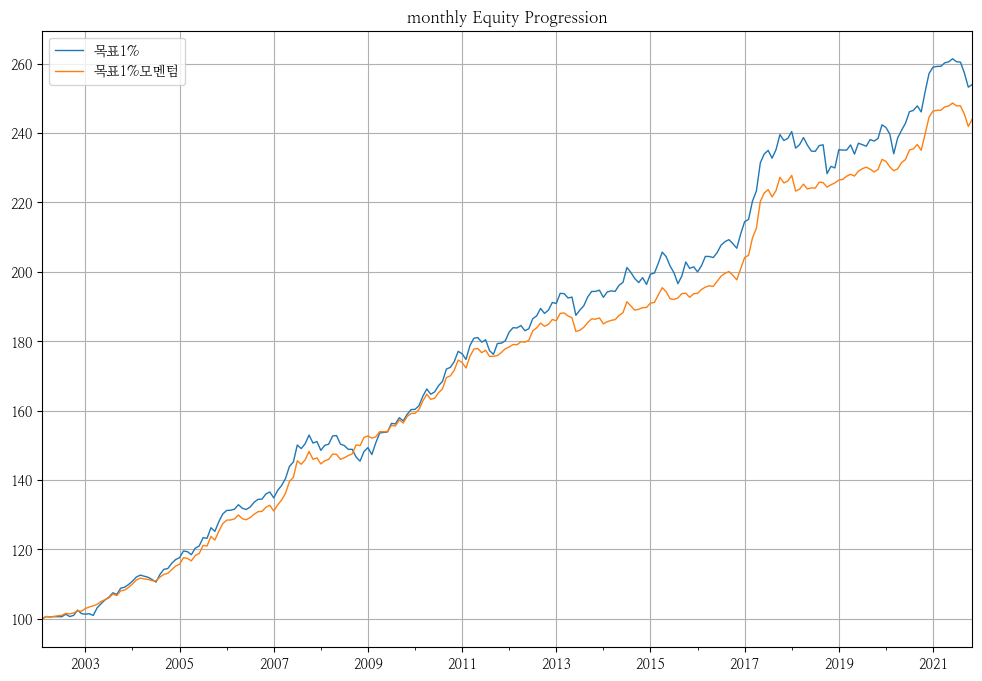

In [18]:
r1.set_date_range(start)

ax1 = r1.plot(freq='M', figsize=(12,8));
r11.plot(ax=ax1, freq='M', figsize=(12,8));

In [19]:
bt목표2모멘텀 = strategy_targetvol_with_ams("목표2%모멘텀", data_daily, start, targetvol=0.02)
r12 = bt.run(bt목표2모멘텀)


prc : 2002-03-04 00:00:00 2002-02 ~ 2001-02
================== 0.10281837887396596 kodex200   0.195
dtype: float64
2002-03-04 00:00:00 목표2%모멘텀 kodex200:0.195 kbond3y:0.805 

prc : 2002-04-01 00:00:00 2002-03 ~ 2001-03
================== 0.09493641039968012 kodex200   0.211
dtype: float64
2002-04-01 00:00:00 목표2%모멘텀 kodex200:0.211 kbond3y:0.789 

prc : 2002-05-02 00:00:00 2002-04 ~ 2001-04
================== 0.09673613074712104 kodex200   0.207
dtype: float64
2002-05-02 00:00:00 목표2%모멘텀 kodex200:0.190 kbond3y:0.810 

prc : 2002-06-03 00:00:00 2002-05 ~ 2001-05
================== 0.099933906622183 kodex200   0.200
dtype: float64
2002-06-03 00:00:00 목표2%모멘텀 kodex200:0.150 kbond3y:0.850 

prc : 2002-07-02 00:00:00 2002-06 ~ 2001-06
================== 0.10231819232921982 kodex200   0.195
dtype: float64
2002-07-02 00:00:00 목표2%모멘텀 kodex200:0.130 kbond3y:0.870 

prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07
================== 0.09850808220349169 kodex200   0.203
dtype: float64
2002-08-01 00:00

In [20]:
bt목표2 = strategy_targetvol("목표2%", data_daily, after_date, targetvol=0.02)
r목표2 = bt.run(bt목표2)


prc : 2002-02-01 00:00:00 2002-01 ~ 2001-01
2002-02-01 00:00:00 목표2% kodex200:0.191 kbond3y:0.809 

prc : 2002-03-04 00:00:00 2002-02 ~ 2001-02
2002-03-04 00:00:00 목표2% kodex200:0.195 kbond3y:0.805 

prc : 2002-04-01 00:00:00 2002-03 ~ 2001-03
2002-04-01 00:00:00 목표2% kodex200:0.211 kbond3y:0.789 

prc : 2002-05-02 00:00:00 2002-04 ~ 2001-04
2002-05-02 00:00:00 목표2% kodex200:0.207 kbond3y:0.793 

prc : 2002-06-03 00:00:00 2002-05 ~ 2001-05
2002-06-03 00:00:00 목표2% kodex200:0.200 kbond3y:0.800 

prc : 2002-07-02 00:00:00 2002-06 ~ 2001-06
2002-07-02 00:00:00 목표2% kodex200:0.195 kbond3y:0.805 

prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07
2002-08-01 00:00:00 목표2% kodex200:0.203 kbond3y:0.797 

prc : 2002-09-02 00:00:00 2002-08 ~ 2001-08
2002-09-02 00:00:00 목표2% kodex200:0.204 kbond3y:0.796 

prc : 2002-10-01 00:00:00 2002-09 ~ 2001-09
2002-10-01 00:00:00 목표2% kodex200:0.205 kbond3y:0.795 

prc : 2002-11-01 00:00:00 2002-10 ~ 2001-10
2002-11-01 00:00:00 목표2% kodex200:0.216 kbond3y:0.784 


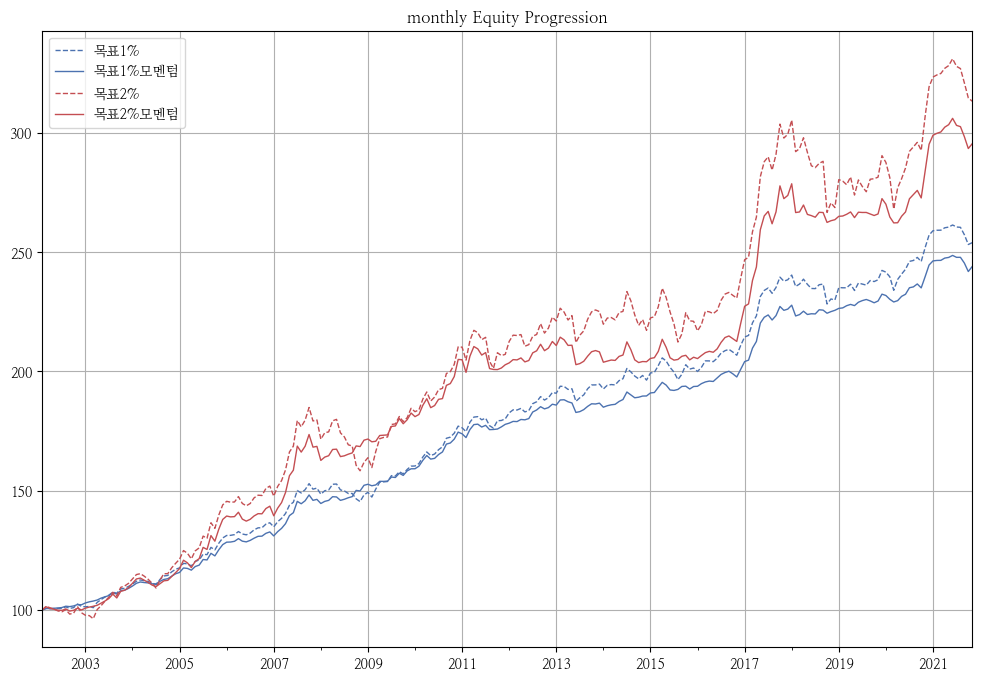

In [21]:
r목표1 = bt.run(bt목표1)
r목표2 = bt.run(bt목표2)
r목표1모멘텀 = bt.run(bt목표1모멘텀)
r목표2모멘텀 = bt.run(bt목표2모멘텀)
r목표1.set_date_range(start)
r목표2.set_date_range(start)
r목표1모멘텀.set_date_range(start)
r목표2모멘텀.set_date_range(start)

ax1 = r목표1.plot(freq='M', color='b', ls='--', figsize=(12, 8));
r목표1모멘텀.plot(ax=ax1, freq='M', color='b', ls='-', figsize=(12, 8));
r목표2.plot(ax=ax1, freq='M', color='r', ls='--', figsize=(12, 8));
r목표2모멘텀.plot(ax=ax1, freq='M', color='r', ls='-', figsize=(12, 8));

In [22]:
r_all = bt.run(bt목표1, bt목표1모멘텀, bt목표2, bt목표2모멘텀)
r_all.set_date_range(start)
r_all.display()

Stat                 목표1%      목표1%모멘텀    목표2%      목표2%모멘텀
-------------------  ----------  --------------  ----------  --------------
Start                2002-02-01  2002-02-01      2002-02-01  2002-02-01
End                  2021-12-30  2021-12-30      2021-12-30  2021-12-30
Risk-free rate       0.00%       0.00%           0.00%       0.00%

Total Return         160.79%     147.95%         228.80%     196.27%
Daily Sharpe         1.22        1.56            0.80        1.01
Daily Sortino        1.99        2.50            1.28        1.57
CAGR                 4.93%       4.67%           6.16%       5.61%
Max Drawdown         -7.67%      -4.71%          -18.59%     -9.48%
Calmar Ratio         0.64        0.99            0.33        0.59

MTD                  1.13%       0.09%           2.34%       0.26%
3m                   -0.18%      -0.49%          -0.11%      -0.73%
6m                   -1.74%      -1.78%          -3.16%      -3.23%
YTD                  -0.12%      -0.16%       

In [23]:
r_all.prices.resample('M').last().to_drawdown_series().min()

목표1%      -0.050
목표1%모멘텀   -0.028
목표2%      -0.144
목표2%모멘텀   -0.063
dtype: float64